In [1]:
import json
import re 
import copy
import graphviz

from importlib import reload

In [2]:
import sys
import clingo
import clingo.symbol as symbol

In [3]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")


thisdir = /home/luke/git/external/asp_recipe_graphs/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/asp_recipe_graphs/notebooks', '/home/luke/git/external/asp_recipe_graphs', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [30]:
## local modules
os.environ["GRASP_SRC_DIR"] = '..'

import asp_recipe_graphs.api.modules
reload(asp_recipe_graphs.api.modules)

from asp_recipe_graphs.api.modules import MODULES
from asp_recipe_graphs.api.modules import RE_FIND_TERMS
from asp_recipe_graphs.api.modules import RE_IS_DEFINITION
from asp_recipe_graphs.api.modules import ASP_MODULE_DEFINES
from asp_recipe_graphs.api.modules import ASP_MODULE_USES
from asp_recipe_graphs.api.modules import DEPENDENCY_MAP
from asp_recipe_graphs.api.modules import ALL_DEFINED
from asp_recipe_graphs.api.modules import ALL_USES
from asp_recipe_graphs.api.modules import UNDEFINED_TERMS
from asp_recipe_graphs.api.modules import get_dependencies
from asp_recipe_graphs.api.modules import what_defines
from asp_recipe_graphs.api.modules import what_uses

import asp_recipe_graphs.api.asp2graph
reload(asp_recipe_graphs.api.asp2graph)
from asp_recipe_graphs.api.asp2graph import create_dependency_graph
from asp_recipe_graphs.api.asp2graph import get_graphs
from asp_recipe_graphs.api.asp2graph import typed_arcs_to_dot
from asp_recipe_graphs.api.asp2graph import get_type_functions
from asp_recipe_graphs.api.asp2graph import get_recipes
from asp_recipe_graphs.api.asp2graph import recipe_graph_to_dot



## Modules

There are a number of asp modules, which define and use terms, and these are subject to change. The python module `asp_recipe_graphs.asp.modules` provides functionality that interrogates these modules and gives information on this. In particular, there is information on which modules define and use which terms, which modules directly depend on other modules, and getting a full dependency chain for a given module or set of modules.

In [5]:
print(f"asp_module_defines = {ASP_MODULE_DEFINES}")
print()
print("Uses")
for m, uses in ASP_MODULE_USES.items():
    print(f"\t{m} uses {uses}")
print()
print(f"undefined_terms = {UNDEFINED_TERMS}")
print()

asp_module_defines = {'acceptability': {'acceptable_recipe'}, 'composition': {'empty_intersection', 'incompatible_node_types', 'composable'}, 'equivalence': {'equivalent'}, 'granularity': {'finer_grained', 'mapped_to_by_g_function', 'not_same_recipe', 'path_or_equal', 'more_specific'}, 'graph_properties': {'connected', 'has_incoming_arc', 'connected_in', 'is_node', 'has_outgoing_arc', 'graph', 'cyclic', 'path'}, 'in_out_aligned': {'in_out_aligned'}, 'isomorphisms': {'isomorphic'}, 'recipe_graphs': {'recipe', 'recipe_graph', 'high_indexes_allowed', 'graph', 'strict_subrecipe_graph', 'subrecipe_graph_of', 'atomic_recipe_graph', 'given_recipe_graph'}, 'subrecipes': {'subrecipe_of'}, 'type_hierarchies': {'same_type_path', 'subtype_or_equal', 'subtype', 'action_type', 'comestible_type'}, 'universal_types': {'child'}}

Uses
	acceptability uses {'acceptability_tuple', 'a', 'arcs', 'recipe', 'in', 'arc', 'type_of', 'c'}
	composition uses {'same_type_path', 'mid', 'join_types_match', 'compositi

In [6]:
# MODULES tells us what modules are defined (domain independent)
MODULES

['acceptability',
 'composition',
 'equivalence',
 'granularity',
 'graph_properties',
 'in_out_aligned',
 'isomorphisms',
 'recipe_graphs',
 'subrecipes',
 'type_hierarchies',
 'universal_types']

In [7]:
# all terms that have been defined in at least one module,
print(f"ALL_DEFINED = {ALL_DEFINED}", end='\n\n')
# all terms that are used in at least one module
print(f"ALL_USES = {ALL_USES}", end='\n\n')
# all terms that are used but not defined
print(f"UNDEFINED_TERMS = {UNDEFINED_TERMS}")


ALL_DEFINED = {'same_type_path', 'equivalent', 'child', 'recipe_graph', 'high_indexes_allowed', 'is_node', 'subrecipe_of', 'subtype', 'not_same_recipe', 'isomorphic', 'subtype_or_equal', 'in_out_aligned', 'strict_subrecipe_graph', 'comestible_type', 'given_recipe_graph', 'composable', 'connected', 'finer_grained', 'empty_intersection', 'has_incoming_arc', 'connected_in', 'action_type', 'graph', 'subrecipe_graph_of', 'mapped_to_by_g_function', 'path', 'acceptable_recipe', 'has_outgoing_arc', 'recipe', 'incompatible_node_types', 'cyclic', 'atomic_recipe_graph', 'path_or_equal', 'more_specific'}

ALL_USES = {'same_type_path', 'mid', 'g_function', 'is_a_node', 'join_types_match', 'composition', 'child', 'recipe_graph', 'out', 'a_nodes', 'isomorphic', 'bijection', 'acts', 'a_node_properly_connected', 'out_types', 'set_of', 'arcs', 'c_nodes', 'subtype_or_equal', 'given_recipe', 'in_out_aligned', 'numbered_mixture', 'type_of', 'comestible_type', 'acceptability_tuple', 'a', 'connected', 'int',

In [8]:
# what_defines(...) asks what module defines a given term 
# (if more than one module defines a term it returns the first module detected)
what_defines('child')

'universal_types'

In [9]:
# what_uses(...) asks what modules use a given term.
what_uses('child')

['type_hierarchies']

In [10]:
# DEPENDENCY_MAP map shows the direct dependencies between modules. 
print(f"dependency_map = {DEPENDENCY_MAP}")

dependency_map = {'acceptability': {'recipe_graphs'}, 'composition': {'type_hierarchies', 'recipe_graphs'}, 'equivalence': {'recipe_graphs', 'isomorphisms'}, 'granularity': {'type_hierarchies', 'isomorphisms', 'in_out_aligned', 'graph_properties', 'recipe_graphs'}, 'graph_properties': set(), 'in_out_aligned': {'recipe_graphs'}, 'isomorphisms': {'recipe_graphs'}, 'recipe_graphs': {'graph_properties', 'type_hierarchies'}, 'subrecipes': {'recipe_graphs'}, 'type_hierarchies': {'universal_types'}, 'universal_types': set()}


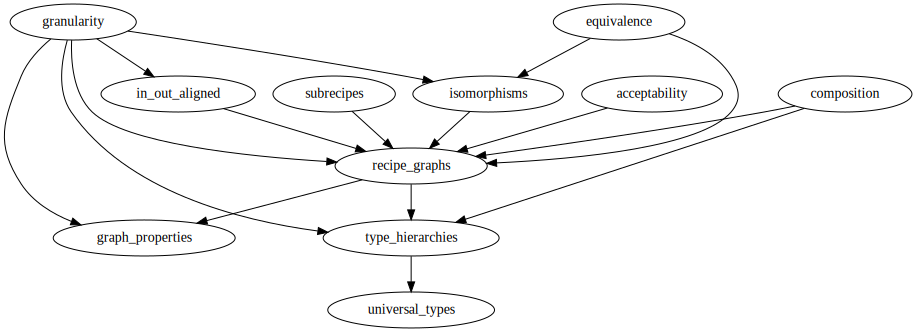

In [11]:
# def create_dependency_graph(dependency_map):
#     dot = graphviz.Digraph()
#     node_ids = {}
#     for i,k in enumerate(dependency_map.keys()):
#         print(f"i,k : {i,k}")
#         node_ids[k] = 'n'+str(i)
# #         dot.node(i, label=k, style='filled', color='yellow', shape='box')
#         dot.node(k, label=k)
#     for source, targets in dependency_map.items():
# #         sid = node_ids[source]
#         for target in targets:
# #             tid = node_ids[target]
#             dot.edge(source,target)
#     return dot
# create_dependency_graph creates a graph of the module dependencies
create_dependency_graph(DEPENDENCY_MAP)

In [12]:
# get_dependencies(...) resolves the full chain of dependencies for one or more modules.
specified = ['acceptability']
get_dependencies(specified)


{'acceptability',
 'graph_properties',
 'recipe_graphs',
 'type_hierarchies',
 'universal_types'}

# Running ASP

In [31]:
from asp_recipe_graphs.api.solver import load_and_solve


In [34]:
fpaths = ['../asp_recipe_graphs/asp/recipes/hummus_graph.lp']
fpaths.append('../asp_recipe_graphs/asp/recipes/hummus_types.lp')
#    fpaths = ['asp_recipe_graphs/asp/recipes/cannellini_hummus_graph.lp']
#    fpaths = ['asp_recipe_graphs/asp/recipes/cannellini_hummus_types.lp']
#    load_and_solve('connected', fpaths)    
#    load_and_solve('cyclic', fpaths)    
#    load_and_solve('arcs',fpaths)       
#    load_and_solve('types',fpaths)       
load_and_solve('recipes',fpaths)       


loading...
fpath =../asp_recipe_graphs/asp/domain_independent/type_hierarchies.lp
fpath =../asp_recipe_graphs/asp/domain_independent/universal_types.lp
fpath =../asp_recipe_graphs/asp/domain_independent/graph_properties.lp
fpath =../asp_recipe_graphs/asp/domain_independent/recipe_graphs.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_graph.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_types.lp
Answer: in(arcs(rg_hummus),arc(c(0),a(0))) in(arcs(rg_hummus),arc(a(0),c(6))) in(arcs(rg_hummus),arc(c(1),a(1))) in(arcs(rg_hummus),arc(c(2),a(1))) in(arcs(rg_hummus),arc(c(3),a(1))) in(arcs(rg_hummus),arc(c(4),a(1))) in(arcs(rg_hummus),arc(c(5),a(1))) in(arcs(rg_hummus),arc(c(6),a(1))) in(arcs(rg_hummus),arc(a(1),c(8))) in(arcs(rg_hummus),arc(c(7),a(2))) in(arcs(rg_hummus),arc(a(2),c(9))) in(arcs(rg_hummus),arc(c(8),a(3))) in(arcs(rg_hummus),arc(c(9),a(3))) in(arcs(rg_hummus),arc(a(3),c(10))) in(acts(rg_hummus),a(0)) in(acts(rg_hummus),a(1)) in(acts(rg_hummus),a(2)) in(acts(rg_hummus),a(3)

# Processing ASP Output

## Graphs (unlabelled)

In [13]:
# we can get asp models for just the graphs by running the query "arcs"
# in asp_recipe_graphs.api.solver.load_and_solve
asp_model = 'in(arcs(rg_hummus),arc(c(0),a(0))) in(arcs(rg_hummus),arc(a(0),c(6))) in(arcs(rg_hummus),arc(c(1),a(1))) in(arcs(rg_hummus),arc(c(2),a(1))) in(arcs(rg_hummus),arc(c(3),a(1))) in(arcs(rg_hummus),arc(c(4),a(1))) in(arcs(rg_hummus),arc(c(5),a(1))) in(arcs(rg_hummus),arc(c(6),a(1))) in(arcs(rg_hummus),arc(a(1),c(8))) in(arcs(rg_hummus),arc(c(7),a(2))) in(arcs(rg_hummus),arc(a(2),c(9))) in(arcs(rg_hummus),arc(c(8),a(3))) in(arcs(rg_hummus),arc(c(9),a(3))) in(arcs(rg_hummus),arc(a(3),c(10))) in(a_nodes(rg_hummus),a(0)) in(a_nodes(rg_hummus),a(1)) in(a_nodes(rg_hummus),a(2)) in(a_nodes(rg_hummus),a(3)) in(c_nodes(rg_hummus),c(0)) in(c_nodes(rg_hummus),c(1)) in(c_nodes(rg_hummus),c(2)) in(c_nodes(rg_hummus),c(3)) in(c_nodes(rg_hummus),c(4)) in(c_nodes(rg_hummus),c(5)) in(c_nodes(rg_hummus),c(6)) in(c_nodes(rg_hummus),c(7)) in(c_nodes(rg_hummus),c(8)) in(c_nodes(rg_hummus),c(9)) in(c_nodes(rg_hummus),c(10)) in(nodes(rg_hummus),a(0)) in(nodes(rg_hummus),a(1)) in(nodes(rg_hummus),a(2)) in(nodes(rg_hummus),a(3)) in(nodes(rg_hummus),c(0)) in(nodes(rg_hummus),c(1)) in(nodes(rg_hummus),c(2)) in(nodes(rg_hummus),c(3)) in(nodes(rg_hummus),c(4)) in(nodes(rg_hummus),c(5)) in(nodes(rg_hummus),c(6)) in(nodes(rg_hummus),c(7)) in(nodes(rg_hummus),c(8)) in(nodes(rg_hummus),c(9)) in(nodes(rg_hummus),c(10))'
asp_model = 'in(arcs(rg_cannellini_hummus),arc(c(0),a(0))) in(arcs(rg_cannellini_hummus),arc(c(1),a(0))) in(arcs(rg_cannellini_hummus),arc(c(2),a(0))) in(arcs(rg_cannellini_hummus),arc(a(0),c(3))) in(arcs(rg_cannellini_hummus),arc(c(4),a(1))) in(arcs(rg_cannellini_hummus),arc(a(1),c(5))) in(arcs(rg_cannellini_hummus),arc(c(6),a(2))) in(arcs(rg_cannellini_hummus),arc(a(2),c(7))) in(arcs(rg_cannellini_hummus),arc(c(8),a(3))) in(arcs(rg_cannellini_hummus),arc(a(3),c(9))) in(arcs(rg_cannellini_hummus),arc(c(10),a(5))) in(arcs(rg_cannellini_hummus),arc(a(5),c(11))) in(arcs(rg_cannellini_hummus),arc(c(12),a(6))) in(arcs(rg_cannellini_hummus),arc(a(6),c(13))) in(arcs(rg_cannellini_hummus),arc(c(5),a(7))) in(arcs(rg_cannellini_hummus),arc(c(7),a(7))) in(arcs(rg_cannellini_hummus),arc(c(9),a(7))) in(arcs(rg_cannellini_hummus),arc(c(13),a(7))) in(arcs(rg_cannellini_hummus),arc(a(7),c(14))) in(arcs(rg_cannellini_hummus),arc(c(3),a(8))) in(arcs(rg_cannellini_hummus),arc(c(14),a(8))) in(arcs(rg_cannellini_hummus),arc(a(8),c(15))) in(arcs(rg_cannellini_hummus),arc(c(8),a(9))) in(arcs(rg_cannellini_hummus),arc(a(9),c(9))) in(arcs(rg_cannellini_hummus),arc(c(3),a(7))) in(arcs(rg_cannellini_hummus),arc(c(14),a(7))) in(arcs(rg_cannellini_hummus),arc(a(7),c(15))) in(a_nodes(rg_cannellini_hummus),a(0)) in(a_nodes(rg_cannellini_hummus),a(1)) in(a_nodes(rg_cannellini_hummus),a(2)) in(a_nodes(rg_cannellini_hummus),a(3)) in(a_nodes(rg_cannellini_hummus),a(5)) in(a_nodes(rg_cannellini_hummus),a(6)) in(a_nodes(rg_cannellini_hummus),a(7)) in(a_nodes(rg_cannellini_hummus),a(8)) in(a_nodes(rg_cannellini_hummus),a(9)) in(c_nodes(rg_cannellini_hummus),c(0)) in(c_nodes(rg_cannellini_hummus),c(1)) in(c_nodes(rg_cannellini_hummus),c(2)) in(c_nodes(rg_cannellini_hummus),c(4)) in(c_nodes(rg_cannellini_hummus),c(6)) in(c_nodes(rg_cannellini_hummus),c(8)) in(c_nodes(rg_cannellini_hummus),c(10)) in(c_nodes(rg_cannellini_hummus),c(12)) in(c_nodes(rg_cannellini_hummus),c(5)) in(c_nodes(rg_cannellini_hummus),c(7)) in(c_nodes(rg_cannellini_hummus),c(9)) in(c_nodes(rg_cannellini_hummus),c(13)) in(c_nodes(rg_cannellini_hummus),c(3)) in(c_nodes(rg_cannellini_hummus),c(14)) in(c_nodes(rg_cannellini_hummus),c(11)) in(c_nodes(rg_cannellini_hummus),c(15)) in(nodes(rg_cannellini_hummus),a(0)) in(nodes(rg_cannellini_hummus),a(1)) in(nodes(rg_cannellini_hummus),a(2)) in(nodes(rg_cannellini_hummus),a(3)) in(nodes(rg_cannellini_hummus),a(5)) in(nodes(rg_cannellini_hummus),a(6)) in(nodes(rg_cannellini_hummus),a(7)) in(nodes(rg_cannellini_hummus),a(8)) in(nodes(rg_cannellini_hummus),a(9)) in(nodes(rg_cannellini_hummus),c(0)) in(nodes(rg_cannellini_hummus),c(1)) in(nodes(rg_cannellini_hummus),c(2)) in(nodes(rg_cannellini_hummus),c(4)) in(nodes(rg_cannellini_hummus),c(6)) in(nodes(rg_cannellini_hummus),c(8)) in(nodes(rg_cannellini_hummus),c(10)) in(nodes(rg_cannellini_hummus),c(12)) in(nodes(rg_cannellini_hummus),c(5)) in(nodes(rg_cannellini_hummus),c(7)) in(nodes(rg_cannellini_hummus),c(9)) in(nodes(rg_cannellini_hummus),c(13)) in(nodes(rg_cannellini_hummus),c(3)) in(nodes(rg_cannellini_hummus),c(14)) in(nodes(rg_cannellini_hummus),c(11)) in(nodes(rg_cannellini_hummus),c(15))'

In [14]:
# get_graphs(...) extracts a collection of arcs for each unique graph in an asp model
# output string
graphs = get_graphs(asp_model)
graphs

{'rg_cannellini_hummus': [{'type_': 'ca', 'source': 'c0', 'target': 'a0'},
  {'type_': 'ca', 'source': 'c1', 'target': 'a0'},
  {'type_': 'ca', 'source': 'c2', 'target': 'a0'},
  {'type_': 'ac', 'source': 'a0', 'target': 'c3'},
  {'type_': 'ca', 'source': 'c4', 'target': 'a1'},
  {'type_': 'ac', 'source': 'a1', 'target': 'c5'},
  {'type_': 'ca', 'source': 'c6', 'target': 'a2'},
  {'type_': 'ac', 'source': 'a2', 'target': 'c7'},
  {'type_': 'ca', 'source': 'c8', 'target': 'a3'},
  {'type_': 'ac', 'source': 'a3', 'target': 'c9'},
  {'type_': 'ca', 'source': 'c10', 'target': 'a5'},
  {'type_': 'ac', 'source': 'a5', 'target': 'c11'},
  {'type_': 'ca', 'source': 'c12', 'target': 'a6'},
  {'type_': 'ac', 'source': 'a6', 'target': 'c13'},
  {'type_': 'ca', 'source': 'c5', 'target': 'a7'},
  {'type_': 'ca', 'source': 'c7', 'target': 'a7'},
  {'type_': 'ca', 'source': 'c9', 'target': 'a7'},
  {'type_': 'ca', 'source': 'c13', 'target': 'a7'},
  {'type_': 'ac', 'source': 'a7', 'target': 'c14'},
 

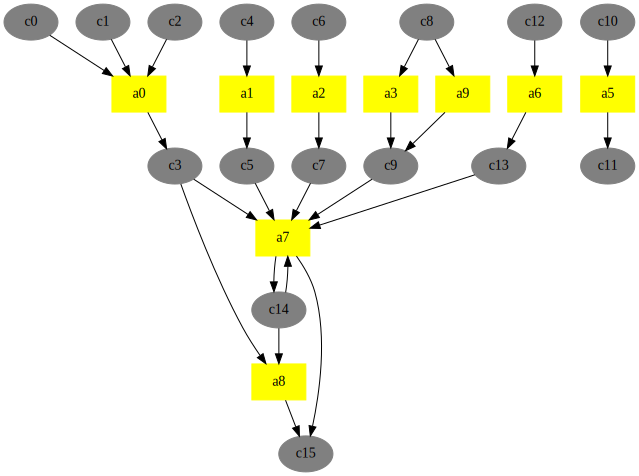

In [15]:
# typed_arcs_to_dot draws the unlabelled graph (good to identify problems)

#dot = typed_arcs_to_dot(graphs['rg_hummus'])
dot = typed_arcs_to_dot(graphs['rg_cannellini_hummus'])
dot

## Types


In [16]:
# we can get asp models for just the type functions by running the query "types"
# in asp_recipe_graphs.api.solver.load_and_solve
asp_model = 'type_of(tf_hummus,c(0),"whole garlic") type_of(tf_hummus,c(1),"tahini") type_of(tf_hummus,c(2),"salt") type_of(tf_hummus,c(3),"lemon juice") type_of(tf_hummus,c(4),"olive oil") type_of(tf_hummus,c(5),"water") type_of(tf_hummus,c(6),"diced garlic") type_of(tf_hummus,c(7),"tinned chick peas") type_of(tf_hummus,c(8),"tahini mixture") type_of(tf_hummus,c(9),"rinsed chick peas") type_of(tf_hummus,c(10),"hummus") type_of(tf_hummus,a(0),"dice") type_of(tf_hummus,a(1),"blend until uniform") type_of(tf_hummus,a(2),"rinse and drain") type_of(tf_hummus,a(3),"blend together")'


In [17]:
# get_type_functions gets a type function mapping for each unique type_function 
# in an asp model string
type_functions = get_type_functions(asp_model)
type_functions

{'tf_hummus': {'c0': '"whole garlic"',
  'c1': '"tahini"',
  'c2': '"salt"',
  'c3': '"lemon juice"',
  'c4': '"olive oil"',
  'c5': '"water"',
  'c6': '"diced garlic"',
  'c7': '"tinned chick peas"',
  'c8': '"tahini mixture"',
  'c9': '"rinsed chick peas"',
  'c10': '"hummus"',
  'a0': '"dice"',
  'a1': '"blend until uniform"',
  'a2': '"rinse and drain"',
  'a3': '"blend together"'}}

# Recipes

In [18]:
# # we can get asp recipes for just the graph, type_function associations
# # by running the query "bare recipes"
# # in asp_recipe_graphs.api.solver.load_and_solve
# asp_model = 'recipe(rg_hummus,tf_hummus)'

# we can get asp recipes including graphs, type_functions and  (graph, type_function)
# associations by running the query "recipes"
# in asp_recipe_graphs.api.solver.load_and_solve
asp_model = ' in(arcs(rg_hummus),arc(c(0),a(0))) in(arcs(rg_hummus),arc(a(0),c(6))) in(arcs(rg_hummus),arc(c(1),a(1))) in(arcs(rg_hummus),arc(c(2),a(1))) in(arcs(rg_hummus),arc(c(3),a(1))) in(arcs(rg_hummus),arc(c(4),a(1))) in(arcs(rg_hummus),arc(c(5),a(1))) in(arcs(rg_hummus),arc(c(6),a(1))) in(arcs(rg_hummus),arc(a(1),c(8))) in(arcs(rg_hummus),arc(c(7),a(2))) in(arcs(rg_hummus),arc(a(2),c(9))) in(arcs(rg_hummus),arc(c(8),a(3))) in(arcs(rg_hummus),arc(c(9),a(3))) in(arcs(rg_hummus),arc(a(3),c(10))) in(acts(rg_hummus),a(0)) in(acts(rg_hummus),a(1)) in(acts(rg_hummus),a(2)) in(acts(rg_hummus),a(3)) in(mid(rg_hummus),c(6)) in(mid(rg_hummus),c(8)) in(mid(rg_hummus),c(9)) in(out(rg_hummus),c(10)) in(in(rg_hummus),c(0)) in(in(rg_hummus),c(1)) in(in(rg_hummus),c(2)) in(in(rg_hummus),c(3)) in(in(rg_hummus),c(4)) in(in(rg_hummus),c(5)) in(in(rg_hummus),c(7)) in(c_nodes(rg_hummus),c(0)) in(c_nodes(rg_hummus),c(1)) in(c_nodes(rg_hummus),c(2)) in(c_nodes(rg_hummus),c(3)) in(c_nodes(rg_hummus),c(4)) in(c_nodes(rg_hummus),c(5)) in(c_nodes(rg_hummus),c(6)) in(c_nodes(rg_hummus),c(7)) in(c_nodes(rg_hummus),c(8)) in(c_nodes(rg_hummus),c(9)) in(c_nodes(rg_hummus),c(10)) in(a_nodes(rg_hummus),a(0)) in(a_nodes(rg_hummus),a(1)) in(a_nodes(rg_hummus),a(2)) in(a_nodes(rg_hummus),a(3)) in(nodes(rg_hummus),a(0)) in(nodes(rg_hummus),a(1)) in(nodes(rg_hummus),a(2)) in(nodes(rg_hummus),a(3)) in(nodes(rg_hummus),c(0)) in(nodes(rg_hummus),c(1)) in(nodes(rg_hummus),c(2)) in(nodes(rg_hummus),c(3)) in(nodes(rg_hummus),c(4)) in(nodes(rg_hummus),c(5)) in(nodes(rg_hummus),c(6)) in(nodes(rg_hummus),c(7)) in(nodes(rg_hummus),c(8)) in(nodes(rg_hummus),c(9)) in(nodes(rg_hummus),c(10)) recipe(rg_hummus,tf_hummus) type_of(tf_hummus,c(0),"whole garlic") type_of(tf_hummus,c(1),"tahini") type_of(tf_hummus,c(2),"salt") type_of(tf_hummus,c(3),"lemon juice") type_of(tf_hummus,c(4),"olive oil") type_of(tf_hummus,c(5),"water") type_of(tf_hummus,c(6),"diced garlic") type_of(tf_hummus,c(7),"tinned chick peas") type_of(tf_hummus,c(8),"tahini mixture") type_of(tf_hummus,c(9),"rinsed chick peas") type_of(tf_hummus,c(10),"hummus") type_of(tf_hummus,a(0),"dice") type_of(tf_hummus,a(1),"blend until uniform") type_of(tf_hummus,a(2),"rinse and drain") type_of(tf_hummus,a(3),"blend together")'

# get_recipes(...) extracts just the graph, type_function associations
# from the asp model string
recipes = get_recipes(asp_model)
recipes

[('rg_hummus', 'tf_hummus')]

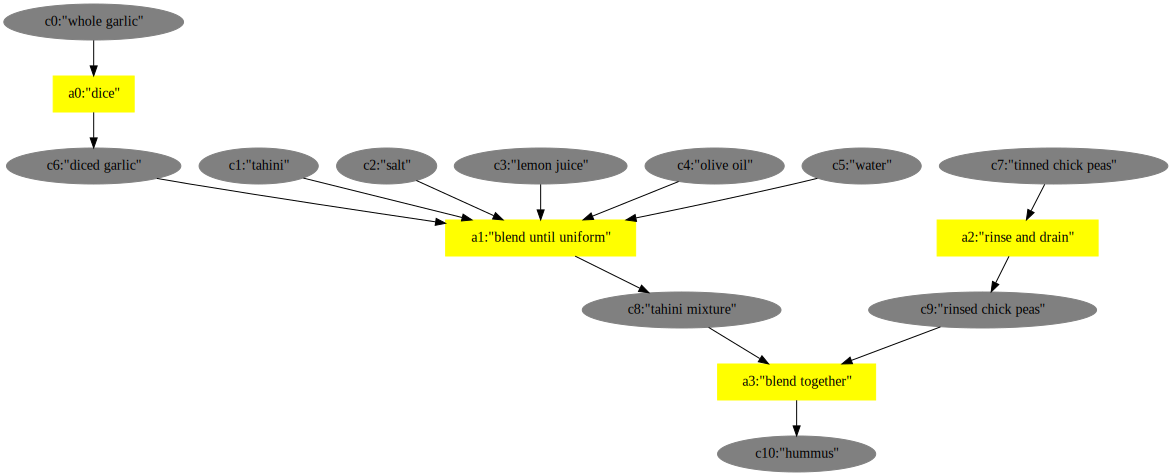

In [19]:
# rerun to get the graphs and type functions
graphs = get_graphs(asp_model)
type_functions = get_type_functions(asp_model)

# recipe_graph_to_dot takes the graphs (collectios of arcs)
# the type_functions and one specific recipe (graph identifier;type
# function identifier pair), then
# finds the associated graph, and type function for that recipe
# and draws it with dot
dot = recipe_graph_to_dot(recipes[0], graphs, type_functions)
dot

## Older code

In [28]:

lp_fnames = ["GraphRecipes.lp","ScratchExample.lp"]
lp_fnames = ["GraphRecipes.lp","SnacksOnToastExample.lp"]

In [29]:
ctl = clingo.Control()
for lp_fname in lp_fnames:
    ctl.load(lp_fname)
ctl.ground([("base", [])])
#answer_sets = []
result = ctl.solve(on_model=lambda m: print("Answer: {}".format(m)))

<cmd>: error: file could not be opened:
  GraphRecipes.lp



RuntimeError: parsing failed

In [ ]:
ctl = clingo.Control()
for lp_fname in lp_fnames:
    ctl.load(lp_fname)
ctl.ground([("base", [])])
models = []
with ctl.solve(yield_=True) as handle:
    for model in handle:
        models.append(model.symbols(shown=True))
models

In [ ]:
for atom in models[0]:
    print(f"atom.type = {atom.type}")
    if atom.type == symbol.SymbolType.Function:
        print(f"atom.name = {atom.name}")
        print(f"atom.arguments = {atom.arguments}")
        print(f"str(atom) = {str(atom)}")
        #print(f"atom.negative = {atom.negative}")
        #print(f"atom.number = {atom.number}")
        #print(f"atom.positive = {atom.positive}")
        #print(f"atom.string = {atom.string}")
